In [1]:
from dipole_inverse_tools import set_max_num_threads
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
set_max_num_threads(4)
import dipole_inverse as dpinv  # noqa: E402

# Inversion

Here we invert a single dipole at different depths. We generated the dipole signal using the point dipole field function using a magnetic moment for a particle of volume 1 micrometer^3, with a magnetization of magnetite: `Ms=4.8e5`.

In the forward model the dipole is modelled as a cuboid of dimensions 1x1x1 micrometer^3. The dipole approximation should  improve as the dipole is deeper in the sample, i.e. farther away from the scan surface.
We start by loading the `Dipole` class

In [2]:
# size of QDM domain
QDM_domain = np.array([[0, 0], [40., 40.]]) * 1e-6
# Spacing between two QDM sample points
QDM_spacing = 2e-6
# half length of QDM sensor
QDM_deltax = 1e-6
# half width of QDM sensor
QDM_deltay = 1e-6
# area of QDM sensor -> necessary? --> use deltax * deltay
QDM_area = 4e-12
# thickness of sample -> Unnecessary
sample_height = 30e-6
# distance between QDM and top sample
scan_height = 2e-6

dip_inversion = dpinv.Dipole(QDM_domain, QDM_spacing,
                             QDM_deltax, QDM_deltay, QDM_area, sample_height,
                             scan_height)

Now we compute the magnetizations from the dipole signal files at different depths:

In [4]:
magnetizations = {}
for depth in [6, 8, 10, 12, 14, 16, 20, 30, 40, 60]:
    print(f'Computing for depth = {depth} micrometers')
    QDM_data = f'./single_dipole_depth_{depth:02d}_Bzgrid.txt'
    cuboid_data = f'./single_dipole_depth_{depth:02d}_cuboids.txt'
    dip_inversion.read_files(QDM_data, cuboid_data, 1e-6)
    # print(dip_inversion.cuboids)

    t = time.time()
    dip_inversion.prepare_matrix(method='cython', verbose=False)
    t = time.time() - t
    print(f'Populating matrix took {t:.6f} s')
    
    dip_inversion.calculate_inverse(method='scipy_pinv2', rcond=1e-25)
    magnetizations[depth] = np.linalg.norm(dip_inversion.Mag.reshape(-1, 3), axis=1)
    print('-' * 60)

Computing for depth = 6 micrometers
Populating matrix took 0.003654 s
Start inversion with 441 knowns and 3 unknowns
Inversion has been carried out
------------------------------------------------------------
Computing for depth = 8 micrometers
Populating matrix took 0.001018 s
Start inversion with 441 knowns and 3 unknowns
Inversion has been carried out
------------------------------------------------------------
Computing for depth = 10 micrometers
Populating matrix took 0.001142 s
Start inversion with 441 knowns and 3 unknowns
Inversion has been carried out
------------------------------------------------------------
Computing for depth = 12 micrometers
Populating matrix took 0.001436 s
Start inversion with 441 knowns and 3 unknowns
Inversion has been carried out
------------------------------------------------------------
Computing for depth = 14 micrometers
Populating matrix took 0.000784 s
Start inversion with 441 knowns and 3 unknowns
Inversion has been carried out
-------------

Now we can plot the magnetization as a function of depth of the dipole. The forward model improves when the dipole is farther away, which means the volume/shape of the dipole becomes less important and the cuboid behaves as a point dipole source:

Text(0, 0.5, 'Ms  A / m')

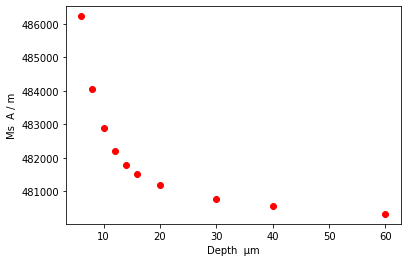

In [5]:
f, ax = plt.subplots()
for k in magnetizations:
    ax.scatter([k], [magnetizations[k][0]], color='red')
ax.set_xlabel('Depth  μm')
ax.set_ylabel('Ms  A / m')

In [6]:
import scipy.optimize as spo
import scipy.interpolate as spi

We can fit the relative error

$$E = \frac{|M(z) - M_{\text{s}}|}{M_{\text{s}}}$$

where $z$ is the dipole depth, with a curve

$$f(z) = a + \frac{b}{z} + \frac{c}{z^2}$$

Therefore the error decreases with depth as approximately $z^{-2}$

In [7]:
def func(x, a, b, c):
    return a + b * x ** -1 + c * x ** -2

Ms = 4.8e5
rel_err_x = [k for k in magnetizations.keys()]
rel_err_y = [abs(magnetizations[k][0] - Ms) / Ms for k in magnetizations.keys()]

popt, pcov = spo.curve_fit(func, rel_err_x, rel_err_y)

In [8]:
popt

array([1.78641414e-04, 3.07157233e-02, 2.76798439e-01])

Text(0, 0.5, 'Rel Error  A / m')

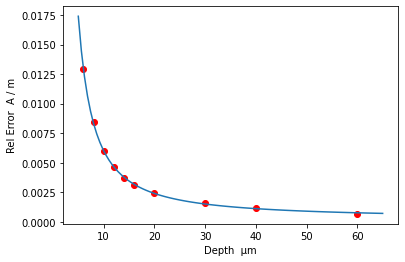

In [9]:
f, ax = plt.subplots()

ax.scatter(rel_err_x, rel_err_y, color='red')

x_i = np.linspace(5, 65, 100)
y_i = func(x_i, *popt)
ax.plot(x_i, y_i)

ax.set_xlabel('Depth  μm')
ax.set_ylabel('Rel Error  A / m')